## Overview

In this notebook, I am comparing: **the percent overlap of a specific library branch (Altgeld) on surrounding census tracts** vs. **corresponding census demographics for those overlapping census tracts**.
To break this down...
- **'percent overlap'** = (area of a census tract that is being covered by a specific distance from Altgeld) / (total area of a census tract)
- **'specific distance'** = either: walking/driving/cycling for some time: 5mins, 10mins, etc **(changing the mode of transportation and time will shift how much area is covered in a census tract)**
- While the census demographics provide ratios for each WHOLE census tract, comparing this with one specific branch (Altgeld) will allow us to see how those demographics fit into ONLY the census tracts that are overlapped by Altgeld. 
- And futher, by using the demographic information, we can compare this within each percent overlap to see the demographic makeup of those areas within each census tract.

<u>Breakdown:<u>
1. **Imports:** reading in **a)** percent overlap information for Altgeld **b)** census demographics dataframe
2. **Merging Census Data with Altgeld Branch:** combining the two dataframes, making sure the 'percent overlap' column from the Altgeld information aligns correctly with the census demographics dataframe
3. **Internet Census Data for Altgeld:** contains function that allows you to pick a specific **internet**-related demographic ratio, and see how it is represented for Altgeld
4. **Income Census Data for Altgeld:** contains function that allows you to pick a specific **income**-related demographic ratio, and see how it is represented for Altgeld
5. **Commute Census Data for Altgeld:** contains function that allows you to pick a specific **commute**-related demographic ratio, and see how it is represented for Altgeld
6. **Race Census Data for Altgeld:** contains function that allows you to pick a specific **race**-related demographic ratio, and see how it is represented for Altgeld
7. **Age Census Data for Altgeld:** contains function that allows you to pick a specific **age**-related demographic ratio, and see how it is represented for Altgeld
8. **Education Census Data for Altgeld:** contains function that allows you to pick a specific **education**-related demographic ratio, and see how it is represented for Altgeld
9. **Creating Branch Snapshot:** combining all of the above functions to create a new function that will display all of the possible values into a DataFrame
10. **Investigations:** looking into specific demographic variables of interest that may tell me something about Altgeld in comparison to all other census tracts

## Imports

In [1]:
#importing necessary libraries
from api.dani_mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [2]:
#Importing file that lists out all of the census tracts that the Altgeld branch overlaps, and gives the actual "Percent Overlap" for each tract
altgeldCensusOverlap = pd.read_csv('../notebooks/altgeldCensusOverlap20Walking1.csv')

In [3]:
#Importing csv that contains all the compiled census information
census_demos = pd.read_csv('../data/final_data/census_demos.csv')

In [4]:
#Checking
census_demos.head(1)

,geoid,qualifying name,geometry,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races
0,17031823303,"Census Tract 8233.03, Cook County, Illinois","POLYGON ((-87.720963 41.683952, -87.720304 41....",4059,0.047056,0.099039,0.075634,0.05223,0.040404,0.069475,...,0.912801,0.087199,0.806432,0.795763,0.078098,0.009855,0.0,0.0,0.072924,0.04336


## Merging Census Data with Altgeld Branch

In [5]:
#Renaming a column to 'geoid' so that it will match the internet_demos file
altgeld = altgeldCensusOverlap.rename(columns={'Census Tract': 'geoid'}, inplace=True)
#Dropping unnecessary columns
altgeld = altgeldCensusOverlap.drop(columns=['Unnamed: 0', 'Area Within Radius', 'census Area'], axis=1)
altgeld

,geoid,geometry,Percent Overlap
0,17031540101,"POLYGON ((-87.583838 41.652592, -87.585686 41....",0.285241
1,17031550200,"MULTIPOLYGON (((-87.584838 41.655959, -87.5834...",0.006462
2,17031540102,"POLYGON ((-87.612095 41.653198, -87.612188 41....",0.235481
3,17031838800,"MULTIPOLYGON (((-87.588132 41.660905, -87.5856...",0.001278


In [6]:
#Merging census_demos with altgeld census overlap file on the geoid so that they match up
altgeld_merge = census_demos.merge(altgeld, on='geoid')

In [7]:
#altgeld_merge is narrowed down to only 11 rows, because only 11 census tracts are covered by altgeld
altgeld_merge

,geoid,qualifying name,geometry_x,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,...,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,geometry_y,Percent Overlap
0,17031540101,"Census Tract 5401.01, Cook County, Illinois","POLYGON ((-87.61728 41.656834, -87.617278 41.6...",4535,0.107607,0.071003,0.143109,0.087982,0.135832,0.087100,...,0.854305,0.035943,0.932304,0.000000,0.0,0.0,0.006395,0.025358,"POLYGON ((-87.583838 41.652592, -87.585686 41....",0.285241
1,17031550200,"Census Tract 5502, Cook County, Illinois","POLYGON ((-87.589141 41.660389, -87.588998 41....",2749,0.042197,0.044744,0.085122,0.055657,0.054202,0.057112,...,0.846654,0.671881,0.038923,0.003638,0.0,0.0,0.208439,0.077119,"MULTIPOLYGON (((-87.584838 41.655959, -87.5834...",0.006462
2,17031540102,"Census Tract 5401.02, Cook County, Illinois","POLYGON ((-87.618065 41.660137, -87.617319 41....",3399,0.110032,0.118564,0.089732,0.084142,0.068844,0.105325,...,0.824759,0.001765,0.991174,0.000000,0.0,0.0,0.000000,0.007061,"POLYGON ((-87.612095 41.653198, -87.612188 41....",0.235481
3,17031838800,"Census Tract 8388, Cook County, Illinois","POLYGON ((-87.601936 41.684742, -87.6019 41.68...",3101,0.052886,0.081264,0.111577,0.101258,0.036440,0.041922,...,0.750000,0.279587,0.583360,0.000000,0.0,0.0,0.137053,0.000000,"MULTIPOLYGON (((-87.588132 41.660905, -87.5856...",0.001278


- The 'geometry' column in census_demos represents the total area for each census tract. 
- The 'geometry' column in altgeld represents the portion of area for each census tract that only the altgeld branch overlaps on.
- Thus, these two 'geometry' columns will not be the same values. So, since we are only looking for overlap, we can remove the 'geometry' column from the census_demos dataframe. When merging, Python changes the census_demos 'geometry' to 'geometry_x' and altgeld's 'geometry' to 'geometry_y'. 

In [8]:
#Dropping geometry_x and renaming geometry_y as just geometry
altgeld_merge_changes = altgeld_merge.drop(columns=['geometry_x'], axis=1).rename(columns={'geometry_y':'geometry'})
altgeld_merge_changes.head()

,geoid,qualifying name,total population,Percent: under 5 years,Percent: 5 to 9 years,Percent: 10 to 14 years,Percent: 15 to 19 years,Percent: 20 to 24 years,Percent: 25 to 29 years,Percent: 30 to 34 years,...,Percent of People with Computers and Internet,Percent: White Alone,Percent: Black or African American Alone,Percent: American Indian and Alaska Native Alone,Percent: Asian Alone,Percent: Native Hawaiian and Other Pacific Islander Alone,Percent: Some Other Race Alone,Percent: Two or More Races,geometry,Percent Overlap
0,17031540101,"Census Tract 5401.01, Cook County, Illinois",4535,0.107607,0.071003,0.143109,0.087982,0.135832,0.087100,0.079162,...,0.854305,0.035943,0.932304,0.000000,0.0,0.0,0.006395,0.025358,"POLYGON ((-87.583838 41.652592, -87.585686 41....",0.285241
1,17031550200,"Census Tract 5502, Cook County, Illinois",2749,0.042197,0.044744,0.085122,0.055657,0.054202,0.057112,0.100764,...,0.846654,0.671881,0.038923,0.003638,0.0,0.0,0.208439,0.077119,"MULTIPOLYGON (((-87.584838 41.655959, -87.5834...",0.006462
2,17031540102,"Census Tract 5401.02, Cook County, Illinois",3399,0.110032,0.118564,0.089732,0.084142,0.068844,0.105325,0.092969,...,0.824759,0.001765,0.991174,0.000000,0.0,0.0,0.000000,0.007061,"POLYGON ((-87.612095 41.653198, -87.612188 41....",0.235481
3,17031838800,"Census Tract 8388, Cook County, Illinois",3101,0.052886,0.081264,0.111577,0.101258,0.036440,0.041922,0.096743,...,0.750000,0.279587,0.583360,0.000000,0.0,0.0,0.137053,0.000000,"MULTIPOLYGON (((-87.588132 41.660905, -87.5856...",0.001278


## Internet Census Data for Altgeld

We want to only look at the internet census information for the Altgeld branch. We need to extract only the internet census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':
- Percent of People with Internet Access
- Percent of People without Internet Access
- Percent of People with Computers
- Percent of People without Computers
- Percent of People with Computers and Internet

*To get a percentage, you write: internet_by_branch('_your pick from above_')

In [9]:
def internet_by_branch(DemographicsVariables):
    ''' We are creating a function that allows me to retrieve only the internet census data, and then compare this with Altgeld'''
    pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['Total']).sum()
    Branch_pop_withInternet = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['Total']).sum() 
    result = Branch_pop_withInternet/pop_in_branch
    return result   

#### Examples of Inputs--checking work

In [10]:
internet_by_branch('Percent of People with Internet Access')

0.8588335896623621

In [11]:
internet_by_branch('Percent of People with Computers')

0.9193808454563297

## Income Census Data for Altgeld

We want to only look at the income census information for the Altgeld branch. We need to extract only the income census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':
- Percent Population in Labor Force 16+: Employed
- Percent Population in Labor Force 16+: Unemployed
- Percent Households: Less Than $10,000

- Percent Households: \\$10,000 to \\$14,999
- Percent Households: \\$15,000 to \\$19,999 
- Percent Households: \\$20,000 to \\$24,999
- Percent Households: \\$25,000 to \\$29,999
- Percent Households: \\$30,000 to \\$34,999
- Percent Households: \\$35,000 to \\$39,999
- Percent Households: \\$40,000 to \\$44,999
- Percent Households: \\$45,000 to \\$49,999
- Percent Households: \\$50,000 to \\$59,999
- Percent Households: \\$60,000 to \\$74,999
- Percent Households: \\$75,000 to \\$99,999
- Percent Households: \\$100,000 to \\$124,999
- Percent Households: \\$125,000 to \\$149,999
- Percent Households: \\$150,000 to \\$199,999
- Percent Households: $200,000 or more
- Percent Ages 18-64: Living in Poverty
- Percent Ages 18-64: At or Above Poverty Level
- Percent Households: With Public Assistance Income
- Percent Households: No Public Assistance Income

*To get a percentage, you write: income_by_branch('_your pick from above_')

In [12]:
def income_by_branch(DemographicsVariables):
    if DemographicsVariables == 'Percent Population in Labor Force 16+: Employed' or DemographicsVariables == 'Percent Population in Labor Force 16+: Unemployed':
        print(DemographicsVariables)
        pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['civilian population in labor force 16 years and over']).sum()
        Branch_pop_withIncome = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['civilian population in labor force 16 years and over']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Households: Less Than $10,000' or DemographicsVariables == 'Percent Households: $10,000 to $14,999' or DemographicsVariables == 'Percent Households: $15,000 to $19,999' or DemographicsVariables == 'Percent Households: $20,000 to $24,999' or DemographicsVariables == 'Percent Households: $25,000 to $29,999' or DemographicsVariables == 'Percent Households: $30,000 to $34,999' or DemographicsVariables == 'Percent Households: $35,000 to $39,999' or DemographicsVariables == 'Percent Households: $40,000 to $44,999' or DemographicsVariables == 'Percent Households: $45,000 to $49,999' or DemographicsVariables == 'Percent Households: $50,000 to $59,999' or DemographicsVariables == 'Percent Households: $60,000 to $74,999' or DemographicsVariables == 'Percent Households: $75,000 to $99,999' or DemographicsVariables == 'Percent Households: $100,000 to $124,999' or DemographicsVariables == 'Percent Households: $125,000 to $149,999' or DemographicsVariables == 'Percent Households: $150,000 to $199,999' or DemographicsVariables == 'Percent Households: $200,000 or more':
        print(DemographicsVariables)
        pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['total households reporting income']).sum()
        Branch_pop_withIncome = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['total households reporting income']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Ages 18-64: Living in Poverty' or DemographicsVariables == 'Percent Ages 18-64: At or Above Poverty Level':
        print(DemographicsVariables)
        pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['population age 18 to 64 for whom poverty status  is determined']).sum()
        Branch_pop_withIncome = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['population age 18 to 64 for whom poverty status  is determined']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Households: With Public Assistance Income' or DemographicsVariables == 'Percent Households: No Public Assistance Income':
        print(DemographicsVariables)
        pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['total households reporting public assistance income status']).sum()
        Branch_pop_withIncome = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['total households reporting public assistance income status']).sum() 
        result = Branch_pop_withIncome/pop_in_branch
        return result

#### Examples of inputs -- checking work

In [13]:
income_by_branch('Percent Population in Labor Force 16+: Unemployed')

Percent Population in Labor Force 16+: Unemployed


0.2648850066796505

In [14]:
income_by_branch('Percent Population in Labor Force 16+: Employed')

Percent Population in Labor Force 16+: Employed


0.7351149933203494

In [15]:
income_by_branch('Percent Households: Less Than $10,000')

Percent Households: Less Than $10,000


0.3870619939917137

In [16]:
income_by_branch('Percent Households: $10,000 to $14,999')

Percent Households: $10,000 to $14,999


0.076630463592059

In [17]:
income_by_branch('Percent Households: $150,000 to $199,999')

Percent Households: $150,000 to $199,999


0.01367308010407841

In [18]:
income_by_branch('Percent Ages 18-64: Living in Poverty')

Percent Ages 18-64: Living in Poverty


0.49537177660362985

In [19]:
income_by_branch('Percent Ages 18-64: At or Above Poverty Level')

Percent Ages 18-64: At or Above Poverty Level


0.5046282233963699

In [20]:
income_by_branch('Percent Households: With Public Assistance Income')

Percent Households: With Public Assistance Income


0.10485158461019195

In [21]:
income_by_branch('Percent Households: No Public Assistance Income')

Percent Households: No Public Assistance Income


0.895148415389808

## Commute Census Data for Altgeld

We want to only look at the commute census information for the Altgeld branch. We need to extract only the commute census information from the census_demos dataset that includes ALL of the census information.

Possible Variables that can be used for 'DemographicsVariables':
    
- Percent Owner and Renter Occupied Housing: No Vehicles
- Percent Owner and Renter Occupied Housing: 1 Vehicle
- Percent Owner and Renter Occupied Housing: 2 Vehicles
- Percent Owner and Renter Occupied Housing: 3 Vehicles
- Percent Owner and Renter Occupied Housing: 4 Vehicles
- Percent Owner and Renter Occupied Housing: 5 or More Vehicles
- Percent Renter-Occupied Housing: No Vehicles
- Percent Renter-Occupied Housing: 1 Vehicle
- Percent Renter-Occupied Housing: 2 Vehicles
- Percent Renter-Occupied Housing: 3 Vehicles
- Percent Renter-Occupied Housing: 4 Vehicles
- Percent Renter-Occupied Housing: 5 or More Vehicles
- Percent Workers 16+: Car, Truck, or Van
- Percent Workers 16+: Drove Alone
- Percent Workers 16+: Carpooled
- Percent Workers 16+: Public Transportation (Includes Taxi)
- Percent Workers 16+: Motorcycle
- Percent Workers 16+: Bicycle
- Percent Workers 16+: Walked
- Percent Workers 16+: Other Means

*To get a percentage, you write: commute_by_branch('_your pick from above_')

In [22]:
def commute_by_branch(DemographicsVariables):
    if DemographicsVariables == 'Percent Owner and Renter Occupied Housing: No Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 1 Vehicle' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 2 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 3 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 4 Vehicles' or DemographicsVariables == 'Percent Owner and Renter Occupied Housing: 5 or More Vehicles':
        print(DemographicsVariables)
        pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['occupied housing units']).sum()
        Branch_pop_withCommute = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['occupied housing units']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Renter-Occupied Housing: No Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 1 Vehicle' or DemographicsVariables == 'Percent Renter-Occupied Housing: 2 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 3 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 4 Vehicles' or DemographicsVariables == 'Percent Renter-Occupied Housing: 5 or More Vehicles':
        print(DemographicsVariables)
        pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['renter-occupied housing units']).sum()
        Branch_pop_withCommute = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['renter-occupied housing units']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result
    elif DemographicsVariables == 'Percent Workers 16+: Car, Truck, or Van ' or DemographicsVariables == 'Percent Workers 16+: Drove Alone' or DemographicsVariables == 'Percent Workers 16+: Carpooled' or DemographicsVariables == 'Percent Workers 16+: Public Transportation (Includes Taxi)' or DemographicsVariables == 'Percent Workers 16+: Motorcycle' or DemographicsVariables == 'Percent Workers 16+: Bicycle' or DemographicsVariables == 'Percent Workers 16+: Walked' or DemographicsVariables == 'Percent Workers 16+: Other Means':
        print(DemographicsVariables)
        pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['workers 16 years and over']).sum()
        Branch_pop_withCommute = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['workers 16 years and over']).sum() 
        result = Branch_pop_withCommute/pop_in_branch
        return result

#### Examples of inputs -- checking work

In [23]:
commute_by_branch('Percent Owner and Renter Occupied Housing: No Vehicles')

Percent Owner and Renter Occupied Housing: No Vehicles


0.4316882190294965

In [24]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 1 Vehicle')

Percent Owner and Renter Occupied Housing: 1 Vehicle


0.4536224512988681

In [25]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 2 Vehicles')

Percent Owner and Renter Occupied Housing: 2 Vehicles


0.08553755890240368

In [26]:
commute_by_branch('Percent Owner and Renter Occupied Housing: 3 Vehicles')

Percent Owner and Renter Occupied Housing: 3 Vehicles


0.022131973395435437

In [27]:
commute_by_branch('Percent Workers 16+: Public Transportation (Includes Taxi)')

Percent Workers 16+: Public Transportation (Includes Taxi)


0.32270486802667947

In [28]:
commute_by_branch('Percent Workers 16+: Bicycle')

Percent Workers 16+: Bicycle


0.0

In [29]:
commute_by_branch('Percent Workers 16+: Car, Truck, or Van ')

Percent Workers 16+: Car, Truck, or Van 


0.5945080006331912

## Race Census Data for Altgeld

We want to only look at the race census information for the Altgeld branch. We need to extract only the race census information from the census_demos dataset that includes ALL of the census information.

Options to Input as DemographicsVariables

- Percent: White Alone
- Percent: Black or African American Alone
- Percent: American Indian and Alaska Native Alone
- Percent: Asian Alone
- Percent: Native Hawaiian and Other Pacific Islander Alone 
- Percent: Some Other Race Alone
- Percent: Two or More Races

*To get a percentage, you write: race_by_branch('_your pick from above_')

In [30]:
def race_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific Race in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['total population']).sum()
    Branch_pop_withRace = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['total population']).sum()
    result = Branch_pop_withRace/pop_in_branch
    return result

#### Examples of inputs -- checking work

In [31]:
race_by_branch('Percent: Black or African American Alone')

Percent: Black or African American Alone


0.9464209724312754

In [32]:
race_by_branch('Percent: Native Hawaiian and Other Pacific Islander Alone')

Percent: Native Hawaiian and Other Pacific Islander Alone


0.0

In [33]:
race_by_branch('Percent: Two or More Races')

Percent: Two or More Races


0.018823244711116897

## Age Census Data for Altgeld

We want to only look at the age census information for the Altgeld branch. We need to extract only the age census information from the census_demos dataset that includes ALL of the census information.

Options to Input as DemographicsVariables

- Percent: under 5 years
- Percent: 5 to 9 years
- Percent: 10 to 14 years
- Percent: 15 to 19 years
- Percent: 20 to 24 years
- Percent: 25 to 29 years
- Percent: 30 to 34 years
- Percent: 35 to 39 years
- Percent: 50 to 54 years
- Percent: 55 to 59 years
- Percent: 60 to 64 years
- Percent: 65 to 69 years
- Percent: 70 to 74 years
- Percent: 75 to 79 years
- Percent: 80 to 84 years
- Percent: 85 years and over

*To get a percentage, you write: age_by_branch('_your pick from above_')

In [34]:
def age_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific age in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['total population']).sum()
    Branch_pop_withAge = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['total population']).sum()
    result = Branch_pop_withAge/pop_in_branch
    return result

#### Examples of Inputs--checking work

In [35]:
age_by_branch('Percent: 75 to 79 years')

Percent: 75 to 79 years


0.004404418189919789

In [36]:
age_by_branch('Percent: 10 to 14 years')

Percent: 10 to 14 years


0.12236994104159646

## Education Census Data for Altgeld

We want to only look at the education census information for the Altgeld branch. We need to extract only the education census information from the census_demos dataset that includes ALL of the census information.

Options to Input as DemographicsVariables

- Percent: 25+ Less Than High School
- Percent: 25+ High School or More
- Percent: 25+ Some College or More Percent: 25+ Bachelor's Degree or More
- Percent: 25+ Master's Degree or More
- Percent: 25+ Professional School Degree or More
- Percent: 25+ Doctorate Degree

*To get a percentage, you write: education_by_branch('_your pick from above_')

In [37]:
def education_by_branch(DemographicsVariables):
    """ This function takes the population of each variables and devide it by the population to give us the perecntage of how many people have a specific degree in the overlapping area of the branch"""
    print(DemographicsVariables)
    pop_in_branch = (altgeld_merge_changes['Percent Overlap']  * altgeld_merge_changes['population 25 years and over']).sum()
    Branch_pop_withEducation = (altgeld_merge_changes['Percent Overlap'] * altgeld_merge_changes[DemographicsVariables] * altgeld_merge_changes['population 25 years and over']).sum()
    result = Branch_pop_withEducation/pop_in_branch
    return result

#### Examples of Inputs--checking work

In [38]:
education_by_branch('Percent: 25+ High School or More')

Percent: 25+ High School or More


0.867684959658198

In [39]:
education_by_branch('Percent: 25+ Professional School Degree or More')

Percent: 25+ Professional School Degree or More


0.00028965242079675323

## Creating Branch Snapshot

My plan is to compare the demographic proportions of Altgeld with the average demographic proportions for all other census tracts. First, I will create a function (branch_demographics) that runs through each demographic variable and returns a value for JUST Altgeld. Then, I will calculate the mean of these proportions for all census tracts. I will then merge the two and compare for any significant differences.

**Dataframe for Altgeld**

In [40]:
#Creating empty DataFrame that will eventually be filled in after running the below function branch_demographics
branch_snapshot_df = pd.DataFrame({'Branch': ['Altgeld']})
branch_snapshot_df

,Branch
0,Altgeld


In [41]:
def branch_demographics(branch_snapshot_df):
    '''This function will iterate through each of the 6 functions previously made, and will print all of the results into the branch_snapshot_df DataFrame'''
    list1 = ['Percent of People with Internet Access',
             'Percent of People without Internet Access',
             'Percent of People with Computers', 
             'Percent of People without Computers', 
             'Percent of People with Computers and Internet']
    for i in list1:
        branch_snapshot_df[i] = internet_by_branch(i)
    
    list2 = ['Percent Population in Labor Force 16+: Employed',
             'Percent Population in Labor Force 16+: Unemployed',
             'Percent Households: Less Than $10,000',
             'Percent Households: $10,000 to $14,999',
             'Percent Households: $15,000 to $19,999',
             'Percent Households: $20,000 to $24,999',
             'Percent Households: $25,000 to $29,999',
             'Percent Households: $30,000 to $34,999',
             'Percent Households: $35,000 to $39,999',
             'Percent Households: $40,000 to $44,999',
             'Percent Households: $45,000 to $49,999',
             'Percent Households: $50,000 to $59,999',
             'Percent Households: $60,000 to $74,999',
             'Percent Households: $75,000 to $99,999',
             'Percent Households: $100,000 to $124,999',
             'Percent Households: $125,000 to $149,999',
             'Percent Households: $150,000 to $199,999',
             'Percent Households: $200,000 or more',
             'Percent Ages 18-64: Living in Poverty',
             'Percent Ages 18-64: At or Above Poverty Level',
             'Percent Households: With Public Assistance Income',
             'Percent Households: No Public Assistance Income']
    for i in list2:
        branch_snapshot_df[i] = income_by_branch(i)
    
    list3 = ['Percent Owner and Renter Occupied Housing: No Vehicles',
             'Percent Owner and Renter Occupied Housing: 1 Vehicle',
             'Percent Owner and Renter Occupied Housing: 2 Vehicles',
             'Percent Owner and Renter Occupied Housing: 3 Vehicles',
             'Percent Owner and Renter Occupied Housing: 4 Vehicles',
             'Percent Owner and Renter Occupied Housing: 5 or More Vehicles',
             'Percent Renter-Occupied Housing: No Vehicles',
             'Percent Renter-Occupied Housing: 1 Vehicle',
             'Percent Renter-Occupied Housing: 2 Vehicles',
             'Percent Renter-Occupied Housing: 3 Vehicles',
             'Percent Renter-Occupied Housing: 4 Vehicles',
             'Percent Renter-Occupied Housing: 5 or More Vehicles',
             'Percent Workers 16+: Car, Truck, or Van ',
             'Percent Workers 16+: Drove Alone',
             'Percent Workers 16+: Carpooled',
             'Percent Workers 16+: Public Transportation (Includes Taxi)',
             'Percent Workers 16+: Motorcycle',
             'Percent Workers 16+: Bicycle',
             'Percent Workers 16+: Walked',
             'Percent Workers 16+: Other Means']
    for i in list3:
        branch_snapshot_df[i] = commute_by_branch(i)
    
    list4 = ['Percent: White Alone',
             'Percent: Black or African American Alone',
             'Percent: American Indian and Alaska Native Alone',
             'Percent: Asian Alone',
             'Percent: Native Hawaiian and Other Pacific Islander Alone',
             'Percent: Some Other Race Alone',
             'Percent: Two or More Races']
    for i in list4:
        branch_snapshot_df[i] = race_by_branch(i)
        
    list5 = ['Percent: under 5 years',
             'Percent: 5 to 9 years',
             'Percent: 10 to 14 years',
             'Percent: 15 to 19 years',
             'Percent: 20 to 24 years',
             'Percent: 25 to 29 years',
             'Percent: 30 to 34 years',
             'Percent: 35 to 39 years',
             'Percent: 50 to 54 years',
             'Percent: 55 to 59 years',
             'Percent: 60 to 64 years',
             'Percent: 65 to 69 years',
             'Percent: 70 to 74 years',
             'Percent: 75 to 79 years',
             'Percent: 80 to 84 years',
             'Percent: 85 years and over']
    for i in list5:
        branch_snapshot_df[i] = age_by_branch(i)
    
    list6 = ['Percent: 25+ Less Than High School', 
             'Percent: 25+ High School or More', 
             'Percent: 25+ Some College or More', 
             'Percent: 25+ Bachelor\'s Degree or More', 
             'Percent: 25+ Master\'s Degree or More',
             'Percent: 25+ Professional School Degree or More',
             'Percent: 25+ Doctorate Degree']
    for i in list6: 
        branch_snapshot_df[i] = education_by_branch(i)
       
    return branch_snapshot_df

In [42]:
branch_demographics(branch_snapshot_df)

Percent Population in Labor Force 16+: Employed
Percent Population in Labor Force 16+: Unemployed
Percent Households: Less Than $10,000
Percent Households: $10,000 to $14,999
Percent Households: $15,000 to $19,999
Percent Households: $20,000 to $24,999
Percent Households: $25,000 to $29,999
Percent Households: $30,000 to $34,999
Percent Households: $35,000 to $39,999
Percent Households: $40,000 to $44,999
Percent Households: $45,000 to $49,999
Percent Households: $50,000 to $59,999
Percent Households: $60,000 to $74,999
Percent Households: $75,000 to $99,999
Percent Households: $100,000 to $124,999
Percent Households: $125,000 to $149,999
Percent Households: $150,000 to $199,999
Percent Households: $200,000 or more
Percent Ages 18-64: Living in Poverty
Percent Ages 18-64: At or Above Poverty Level
Percent Households: With Public Assistance Income
Percent Households: No Public Assistance Income
Percent Owner and Renter Occupied Housing: No Vehicles
Percent Owner and Renter Occupied Hous

,Branch,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,Altgeld,0.858834,0.141166,0.919381,0.080619,0.842875,0.735115,0.264885,0.387062,0.07663,...,0.004404,0.005772,0.008001,0.132315,0.867685,0.493944,0.066593,0.032298,0.00029,0.000069


**Dataframe for Average of all Census Tracts**

In [43]:
census_demos_average = census_demos[['Percent of People with Internet Access',
             'Percent of People without Internet Access',
             'Percent of People with Computers', 
             'Percent of People without Computers', 
             'Percent of People with Computers and Internet',
            'Percent Population in Labor Force 16+: Employed',
             'Percent Population in Labor Force 16+: Unemployed',
             'Percent Households: Less Than $10,000',
             'Percent Households: $10,000 to $14,999',
             'Percent Households: $15,000 to $19,999',
             'Percent Households: $20,000 to $24,999',
             'Percent Households: $25,000 to $29,999',
             'Percent Households: $30,000 to $34,999',
             'Percent Households: $35,000 to $39,999',
             'Percent Households: $40,000 to $44,999',
             'Percent Households: $45,000 to $49,999',
             'Percent Households: $50,000 to $59,999',
             'Percent Households: $60,000 to $74,999',
             'Percent Households: $75,000 to $99,999',
             'Percent Households: $100,000 to $124,999',
             'Percent Households: $125,000 to $149,999',
             'Percent Households: $150,000 to $199,999',
             'Percent Households: $200,000 or more',
             'Percent Ages 18-64: Living in Poverty',
             'Percent Ages 18-64: At or Above Poverty Level',
             'Percent Households: With Public Assistance Income',
             'Percent Households: No Public Assistance Income',
            'Percent Owner and Renter Occupied Housing: No Vehicles',
             'Percent Owner and Renter Occupied Housing: 1 Vehicle',
             'Percent Owner and Renter Occupied Housing: 2 Vehicles',
             'Percent Owner and Renter Occupied Housing: 3 Vehicles',
             'Percent Owner and Renter Occupied Housing: 4 Vehicles',
             'Percent Owner and Renter Occupied Housing: 5 or More Vehicles',
             'Percent Renter-Occupied Housing: No Vehicles',
             'Percent Renter-Occupied Housing: 1 Vehicle',
             'Percent Renter-Occupied Housing: 2 Vehicles',
             'Percent Renter-Occupied Housing: 3 Vehicles',
             'Percent Renter-Occupied Housing: 4 Vehicles',
             'Percent Renter-Occupied Housing: 5 or More Vehicles',
             'Percent Workers 16+: Car, Truck, or Van ',
             'Percent Workers 16+: Drove Alone',
             'Percent Workers 16+: Carpooled',
             'Percent Workers 16+: Public Transportation (Includes Taxi)',
             'Percent Workers 16+: Motorcycle',
             'Percent Workers 16+: Bicycle',
             'Percent Workers 16+: Walked',
             'Percent Workers 16+: Other Means',
            'Percent: White Alone',
             'Percent: Black or African American Alone',
             'Percent: American Indian and Alaska Native Alone',
             'Percent: Asian Alone',
             'Percent: Native Hawaiian and Other Pacific Islander Alone',
             'Percent: Some Other Race Alone',
             'Percent: Two or More Races',
             'Percent: under 5 years',
             'Percent: 5 to 9 years',
             'Percent: 10 to 14 years',
             'Percent: 15 to 19 years',
             'Percent: 20 to 24 years',
             'Percent: 25 to 29 years',
             'Percent: 30 to 34 years',
             'Percent: 35 to 39 years',
             'Percent: 50 to 54 years',
             'Percent: 55 to 59 years',
             'Percent: 60 to 64 years',
             'Percent: 65 to 69 years',
             'Percent: 70 to 74 years',
             'Percent: 75 to 79 years',
             'Percent: 80 to 84 years',
             'Percent: 85 years and over',
            'Percent: 25+ Less Than High School', 
             'Percent: 25+ High School or More', 
             'Percent: 25+ Some College or More', 
             'Percent: 25+ Bachelor\'s Degree or More', 
             'Percent: 25+ Master\'s Degree or More',
             'Percent: 25+ Professional School Degree or More',
             'Percent: 25+ Doctorate Degree']].mean()

In [44]:
census_demos_avg_df = pd.DataFrame(census_demos_average).T
census_demos_avg_df.insert(0, 'Branch', 'Average Census Data')
census_demos_avg_df

,Branch,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,Average Census Data,0.865607,0.134393,0.904691,0.095309,0.826165,0.900613,0.099387,0.089435,0.049482,...,0.023298,0.014911,0.01642,0.142024,0.857976,0.624766,0.384402,0.160552,0.048123,0.016976


In [45]:
#Making DataFrame that combines both Altgeld and Average Census Data
branch_vs_average = pd.concat([branch_snapshot_df, census_demos_avg_df])
branch_vs_average

,Branch,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,Altgeld,0.858834,0.141166,0.919381,0.080619,0.842875,0.735115,0.264885,0.387062,0.076630,...,0.004404,0.005772,0.008001,0.132315,0.867685,0.493944,0.066593,0.032298,0.000290,0.000069
0,Average Census Data,0.865607,0.134393,0.904691,0.095309,0.826165,0.900613,0.099387,0.089435,0.049482,...,0.023298,0.014911,0.016420,0.142024,0.857976,0.624766,0.384402,0.160552,0.048123,0.016976


In [46]:
#Calculating differences
difference_row = branch_vs_average.iloc[0:2,1:78].diff(axis=0)
difference_row

,Percent of People with Internet Access,Percent of People without Internet Access,Percent of People with Computers,Percent of People without Computers,Percent of People with Computers and Internet,Percent Population in Labor Force 16+: Employed,Percent Population in Labor Force 16+: Unemployed,"Percent Households: Less Than $10,000","Percent Households: $10,000 to $14,999","Percent Households: $15,000 to $19,999",...,Percent: 75 to 79 years,Percent: 80 to 84 years,Percent: 85 years and over,Percent: 25+ Less Than High School,Percent: 25+ High School or More,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More,Percent: 25+ Master's Degree or More,Percent: 25+ Professional School Degree or More,Percent: 25+ Doctorate Degree
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0.006774,-0.006774,-0.01469,0.01469,-0.01671,0.165498,-0.165498,-0.297627,-0.027149,-0.02493,...,0.018894,0.009139,0.008418,0.009709,-0.009709,0.130822,0.317809,0.128254,0.047834,0.016907


- When calculating the difference, an unnecessary row of NaN's is made. To make for an easier investigation, I convert this DataFrame of differences to a csv, and then look at the numbers individually in a google sheets file.  

In [47]:
difference_row.to_csv('../notebooks/difference_row.csv')

## Investigations

In [48]:
#Some potential variables that looked signifcant in the google sheets csv
branch_vs_average[['Branch', 
                   'Percent: 25+ Some College or More',
                   'Percent Households: Less Than $10,000', 
                   'Percent Ages 18-64: Living in Poverty', 
                   'Percent Owner and Renter Occupied Housing: No Vehicles',
                  'Percent Owner and Renter Occupied Housing: 2 Vehicles',
                  'Percent Renter-Occupied Housing: No Vehicles',
                  'Percent: Black or African American Alone',
                  'Percent: 25+ Some College or More',
                  'Percent: 25+ Bachelor\'s Degree or More']]

,Branch,Percent: 25+ Some College or More,"Percent Households: Less Than $10,000",Percent Ages 18-64: Living in Poverty,Percent Owner and Renter Occupied Housing: No Vehicles,Percent Owner and Renter Occupied Housing: 2 Vehicles,Percent Renter-Occupied Housing: No Vehicles,Percent: Black or African American Alone,Percent: 25+ Some College or More,Percent: 25+ Bachelor's Degree or More
0,Altgeld,0.493944,0.387062,0.495372,0.431688,0.085538,0.445156,0.946421,0.493944,0.066593
0,Average Census Data,0.624766,0.089435,0.164590,0.239939,0.234915,0.334494,0.331257,0.624766,0.384402


To more easily see the differences between Altgeld and all other census tracts, I can create histograms that shows how many census tracts fall under a certain proportion of a demographic variable. A few that I explored are shown below.

### Income < $10,000 Histogram

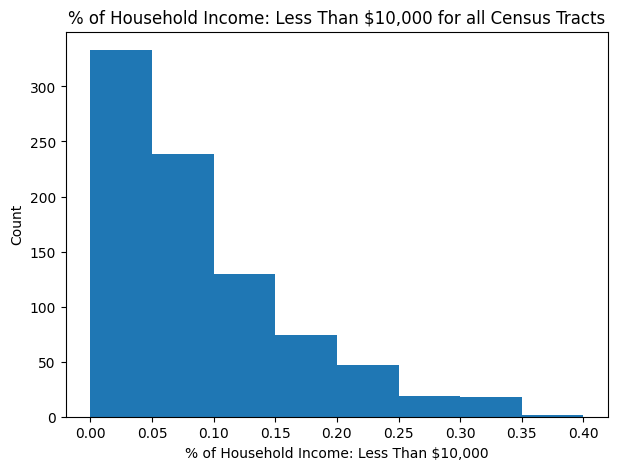

In [49]:
plt.figure(figsize=(7,5)) 

binz = np.arange(0.0,0.45,0.05)                    
plt.hist(x=census_demos['Percent Households: Less Than $10,000'], bins = binz)
plt.xlabel('% of Household Income: Less Than $10,000')                                                     
plt.ylabel('Count')
plt.title('% of Household Income: Less Than $10,000 for all Census Tracts')  
plt.show()

- Altgeld's proportion of 'Percent Households: Less Than $10,000' is 0.38. Based on the above histogram, very very few census tracts fall within the 0.34-0.4. Thus, Altgeld is not within the median of other census tracts.

### Black/African American Proportion Histogram

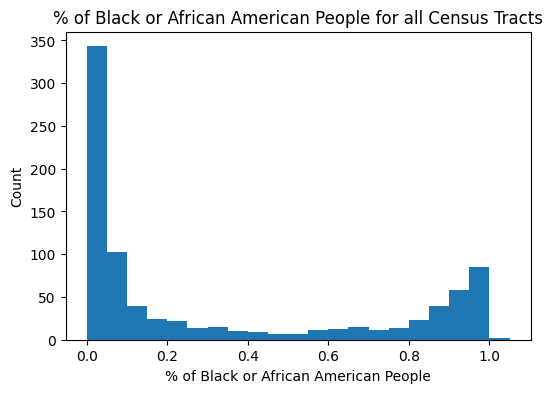

In [50]:
plt.figure(figsize=(6,4)) 

binz = np.arange(0.0,1.1,0.05)                      
plt.hist(x=census_demos['Percent: Black or African American Alone'], bins = binz)
plt.xlabel('% of Black or African American People')                                                     
plt.ylabel('Count')
plt.title('% of Black or African American People for all Census Tracts')  
plt.show()

- Altgeld's proportion of Black or African American People is 0.94. Based on the histogram, it shows that many census tracts either have an extremely small proportion of Black or African American people, or an extremely high proprtion of Black or African American people.

### Poverty Level Histogram

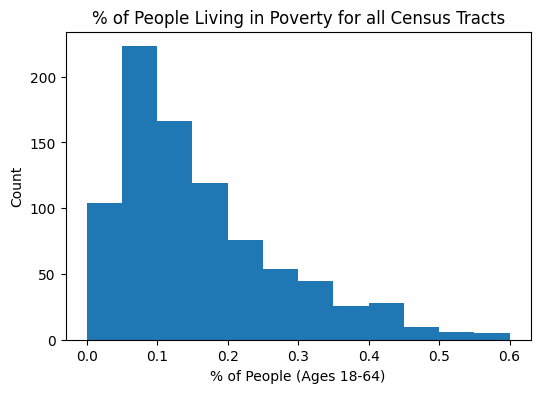

In [51]:
plt.figure(figsize=(6,4)) 

binz = np.arange(0.0,0.65,0.05)                    
plt.hist(x=census_demos['Percent Ages 18-64: Living in Poverty'], bins = binz)
plt.xlabel('% of People (Ages 18-64)')                                                     
plt.ylabel('Count')
plt.title('% of People Living in Poverty for all Census Tracts')  
plt.show()

- Altgeld's proportion of people living in poverty (ages 18-64) is 0.49. Based on the histogram, 0.49 is not within the median. Altgeld's proportion of people has a much higher rate of poverty than the average of all other census tracts.

Conclusion:
- From outside investigation, I have learned that the Altgeld community has historically dealt with disproportionate social issues (environment, health, etc). Through this investigation, I have been able to find another inequity within the community in relation to the access of their library.